<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/ML_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning

In [91]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats

import keras.backend as K
from keras.applications.vgg19 import VGG19

## Import dataset BSD

In [92]:
import pathlib
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='BSDS300',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('images/*/*.jpg')))
image_count_train = len(list(data_dir.glob('images/train/*.jpg')))
image_count_test = len(list(data_dir.glob('images/test/*.jpg')))


print(image_count)

test_temp = list(data_dir.glob('images/test/*'))
train_temp = list(data_dir.glob('images/train/*'))

300


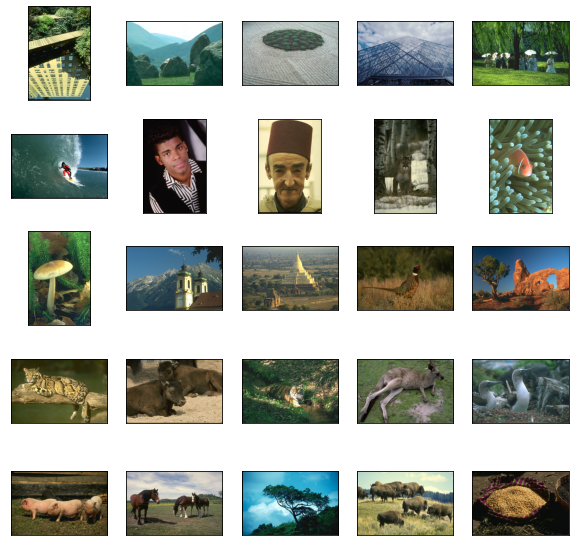

In [93]:
#codice per mostrare alcuni esempi
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PIL.Image.open(str(test_temp[i])), cmap=plt.cm.binary)
   
plt.show()

Codice per salvare le immagini in due array


*   Array di matrici RGB 
*   Array di oggetti immagine

Eseguiamo il crop delle immagini

In [94]:
n=256

test_as_img = []
test_as_arr = []
for i in range(image_count_test):
  image=cv2.imread(str(test_temp[i]))
  image=image[0:n,0:n,0:3]
  test_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  test_as_arr.append(image)
  
train_as_img=[]
train_as_arr=[]
for i in range(image_count_train):
  image=cv2.imread(str(train_temp[i]))
  image=image[0:n,0:n,0:3]
  train_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  train_as_arr.append(image)

image_size=[n,n,3]
print(image_size)


[256, 256, 3]


In [95]:
#plt.figure(figsize=(10,10))
#for i in range(25):
 #   plt.subplot(5,5,i+1)
 #   plt.xticks([])
 #   plt.yticks([])
 #   plt.grid(False)
  #  plt.imshow(test_as_arr[i], cmap=plt.cm.binary)
   
#plt.show()

## Adding Noise

In [96]:
def truncnorm_(lower, upper, sigma):
  mu = (lower+upper)/2

  X = np.random.normal(mu, sigma)

  if(X < lower):
    return lower
  if(X > upper):
    return upper

  return X

In [97]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.005, 0.03
    sigma = 0.005
    var=truncnorm_(lower, upper, sigma)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.02, 0.07
    sigma = 0.01

    amount=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.005, 0.02
    sigma = 0.003

    var=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  return noise_img_rgb #random_noise returns [0,1] or [-1,1] value

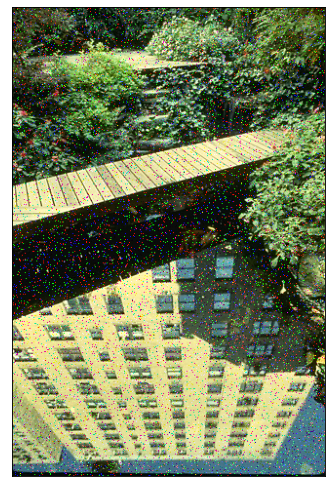

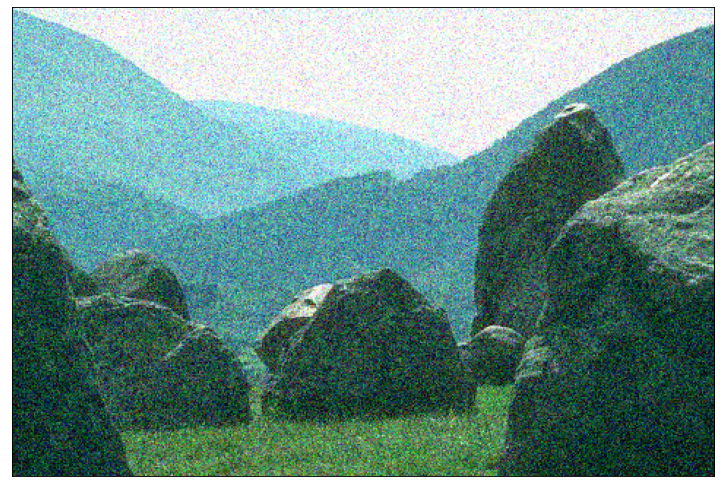

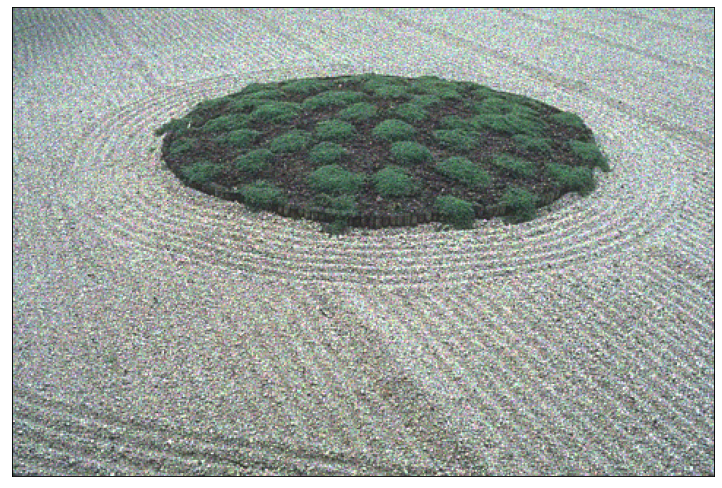

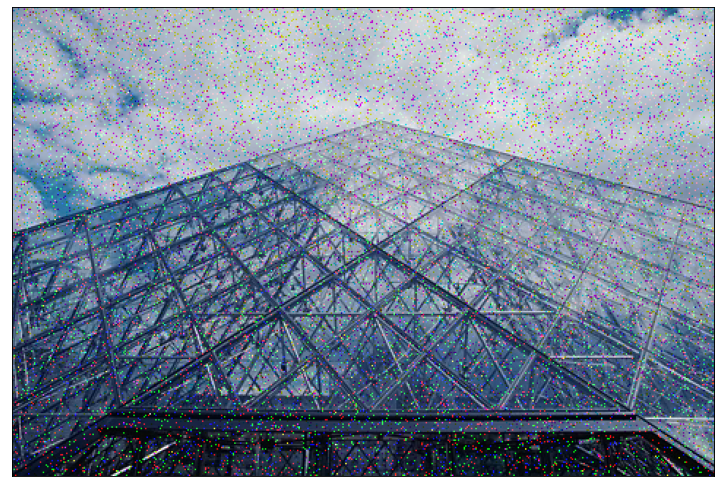

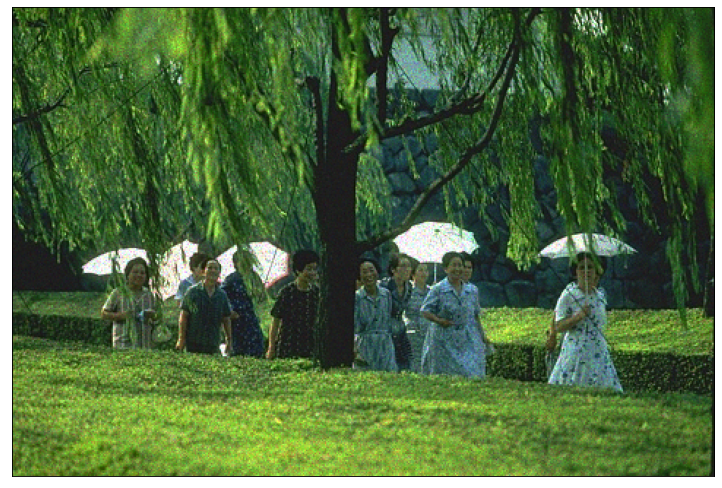

In [98]:
from matplotlib import pyplot as plt

for i in range(5):
    plt.figure(figsize=(50,45), dpi=80)

    img = cv2.imread(str(test_temp[i]))
    noise_img=apply_noise_to_image(img)

    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((noise_img), cmap=plt.cm.binary)
   
plt.show()

## Generatore - Discriminatore 

In [99]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [100]:
image_shape=image_size
print(image_size)

[256, 256, 3]


In [101]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [102]:
@tf.function
def preproces_vgg(x_):
    # scale from [-1,1] to [0, 255]
    x_ += 1.
    x_ *= 127.5

    # RGB -> BGR
    x_ = x_[..., ::-1]
    

    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    x_ = K.bias_add(x_, K.cast(_IMAGENET_MEAN, K.dtype(x_)))

    return x_
  

In [103]:

def vgg_loss(y_true, y_pred):
    # load pretrained VGG
    vgg19 = VGG19(include_top=False,
                  input_shape=(256,256,3), 
                  weights='imagenet')
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False

    # create a model that ouputs the features from level 'block2_conv2'
    features_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer("block2_conv2").output)

    # compute the features, y_pred and y_true are tensors scaled in [-1, 1]
    # it needs te be rescaled and shifted to respect VGG preprocessing strategy
    
    features_pred = features_extractor(preproces_vgg(y_pred))
    features_true = features_extractor(preproces_vgg(y_true))

    # adding the scaling factor (to have similar values as with MSE within image space)
    return 0.006*K.mean(K.square(features_pred - features_true), axis=-1)

In [104]:
# Loss building blocks

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mse = keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mae = keras.losses.MeanAbsoluteError(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
_vgg = None


def _get_vgg19():
    if _vgg is not None:
        return _vgg
    else:
        return keras.applications.VGG19(include_top=False, weights='imagenet')


def vgg19_loss(block_idx, conv_idx):
    mean = tf.constant([103.939, 116.779, 123.68])
    vgg = _get_vgg19()
    vgg_features = keras.models.Model(
        vgg.input,
        vgg.get_layer(f'block{block_idx}_conv{conv_idx}').output)

    def loss(y_true, y_pred):
        features_true = vgg_features((y_true * 255) - mean) / 12.75
        features_pred = vgg_features((y_pred * 255) - mean) / 12.75
        return mse(features_true, features_pred)

    return loss

In [105]:
from numpy.core.fromnumeric import resize
def define_generator(image_shape):
  # weight initialization

  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  # e1 = define_encoder_block(in_image, 64, batchnorm=False)
  # e2 = define_encoder_block(e1, 128)
  # e3 = define_encoder_block(e2, 256)
  # e4 = define_encoder_block(e3, 512)
  # e6 = define_encoder_block(e4, 512)

  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # d1 = decoder_block(b, e6, 512)
  # d2 = decoder_block(d1, e5, 512)
  # d3 = decoder_block(d1, e4, 512)
  # d4 = decoder_block(d3, e3, 256, dropout=False)
  # d5 = decoder_block(d4, e2, 128, dropout=False)
  # d6 = decoder_block(d5, e1, 64, dropout=False)


  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)

  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image, name='Generator')
  
  return model

In [106]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image= Input(shape=image_shape)
	# target image input
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	#d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	#d = BatchNormalization()(d)
	#d = LeakyReLU(alpha=0.2)(d)

	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	#d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	#d = BatchNormalization()(d)
	#d = LeakyReLU(alpha=0.2)(d)
 
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	# patch output
	d = Flatten()(d)
	d = Dense(1024, activation=None)(d)
	d = LeakyReLU(alpha=0.2)(d)
	output_discriminator = Dense(1, activation='sigmoid')(d)

	# define model
	model = Model(in_image, output_discriminator, name='Discriminator')
	# compile model
	opt = Adam(learning_rate=0.000001, beta_1=0.9)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"], loss_weights=[1])
	return model

In [107]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	#for layer in d_model.layers:
	#	if not isinstance(layer, BatchNormalization):
	#		layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	print(in_src.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	############
	#dis_out = d_model(gen_out)
	dis_out = d_model(in_src)
	#############
	# src image as input, generated image and classification output
	model = Model(in_src, [gen_out, dis_out], name='GAN')
	#model = Model(in_src, dis_out, name='GAN')
	# compile model
	opt = Adam(learning_rate=0.000002, beta_1=0.9)
	#model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[1])
	model.compile(loss=['mse', 'binary_crossentropy'], optimizer=opt, loss_weights=[1, 0.1])
	return model


In [108]:
# define the models
d_model = define_discriminator(image_size)
g_model = define_generator(image_size)
# define the composite model
gan_model = define_gan(g_model, d_model, image_size)

(None, 256, 256, 3)


In [109]:
#d_model.summary()

In [110]:
#g_model.summary()

In [111]:
#keras.utils.plot_model(g_model, "Generator.jpg", show_shapes=True)

In [112]:
#gan_model.summary()

## Training

In [113]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [114]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, image_count_train, n_samples)
  ix = np.array(ix).astype(int)
  X = np.zeros((n_samples, 256, 256, 3))
  # retrieve selected images
  for i in range(n_samples):
    X[i]=train_as_arr[ix[i]]
  X = np.reshape(X, (X.shape[0],X.shape[1],X.shape[2],X.shape[3]))
  # generate 'real' class labels (1)
  y = np.ones(n_samples)
  #y = np.ones((n_samples, patch_shape, 1))
  return X , y, ix
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, ix, n_samples, noisy_samples):
  # generate fake instance
  #samples = np.zeros((n_samples, 256, 256, 3))
  #for i in range(n_samples):
  #  samples[i]=apply_noise_to_image(train_as_img[ix[i]])

  #noisy_samples = np.reshape(noisy_samples, (noisy_samples.shape[0], noisy_samples.shape[1], noisy_samples.shape[2], noisy_samples.shape[3]))
  #print("Samples:")
  #print(n_samples)
  #print(noisy_samples.shape)
  
  X = g_model.predict(noisy_samples)
  #print("FakeSamples:")
  #print(X.shape)
  # create 'fake' class labels (0)
  y = np.zeros(n_samples)
  return X , y

In [115]:
# utility function to plot some figures
def plot_figures(x, n, figsize=(30,30), dpi=30):
  plt.figure(figsize=figsize)
  for i in range(n):

    plt.subplot(1,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    #img = ((x[i]*127.5) + 127.5).astype("uint8")
    img = x[i].astype("uint8")
    # rescale for visualization purposes
    plt.imshow(img)

  plt.show()

In [116]:
# TODO: va nel for
		# summarize performance
#		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
#		if (i+1) % (bat_per_epo * 10) == 0:
#			summarize_performance(i, g_model, dataset)

In [117]:
def gen_benchmark_images(img, index):
  noise_choises=["gaussian", "s&p", "speckle"];

  if noise_choises[index]=="gaussian":
    mean=0;
    upper = 0.03
    lower=0.005
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=lower)

  elif noise_choises[index]=="s&p":
    upper = 0.07
    lower=0.02
    noise_img = random_noise(img, mode='s&p', amount=lower)

  elif noise_choises[index]=="speckle":
    upper = 0.02
    lower=0.005
    noise_img = random_noise(img, mode='speckle', var=lower)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  return noise_img_rgb #random_noise returns [0,1] or [-1,1] value

In [118]:
def train(d_model, g_model, gan_model, n_epochs=100, n_batch=1):
  # store benchmark images per epoch
  benchmarkImages=np.zeros((3, 256, 256, 3))
  benchmarkImages[0]=gen_benchmark_images(train_as_img[0], 0)
  benchmarkImages[1]=gen_benchmark_images(train_as_img[0], 1)
  benchmarkImages[2]=gen_benchmark_images(train_as_img[0], 2)
  benchmarkImages = np.reshape(benchmarkImages, (benchmarkImages.shape[0], benchmarkImages.shape[1], benchmarkImages.shape[2], benchmarkImages.shape[3]))
  # define collections of metrics
  history={}
  history['G_loss'] = []
  history['D_loss_true'] = []
  history['D_loss_fake'] = []
  accuracy = {}
  accuracy['Acc_true'] = []
  accuracy['Acc_fake'] = []
  
  # calculate the number of batches per training epoch
  
  # calculate the number of training iterations
  # manually enumerate epochs
  for epoch in range(n_epochs):
    #print("Epoch "+ str(epoch))
    image_per_epoch = int(image_count_train / n_batch)
    # select a batch of real and fake samples 
    X_real, y_real, ix = generate_real_samples(train_as_arr, image_per_epoch)
    
    X_noisy = np.zeros((image_per_epoch, 256, 256, 3))
    for j in range(image_per_epoch):
      img=train_as_img[ix[j]]
      X_noisy[j]=apply_noise_to_image(img)
    X_noisy = np.reshape(X_noisy, (X_noisy.shape[0], X_noisy.shape[1],X_noisy.shape[2],X_noisy.shape[3]))

    for i in range(n_batch):
      #Generate noisy images
      #print("Batch "+ str(i))

      #####################
      # train discriminator
      d_model.trainable=True
      # generate a batch of fake samples
      X_gen, y_fake = generate_fake_samples(g_model, ix, image_per_epoch, X_noisy)
      # update discriminator for original samples
      d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
      history['D_loss_true'].append(d_loss1)
      accuracy['Acc_true'].append(d_acc1)
      # update discriminator for noisy samples
      d_loss2, d_acc2 = d_model.train_on_batch(X_gen, y_fake)
      history['D_loss_fake'].append(d_loss2)
      accuracy['Acc_fake'].append(d_acc2)
      
      ########################
      # train generator
      d_model.trainable=False;
      g_model.trainable=True;
      fake_labels = [1] * image_per_epoch
      fake_labels = np.reshape(fake_labels, (-1,))
      g_loss, _, _ = gan_model.train_on_batch(X_noisy, [X_real, fake_labels])
      history['G_loss'].append(g_loss)
   
    print("epoch " + str(epoch) + ": discriminator loss true " + str(d_loss1)+  " ( "  + str(d_acc1) + " ) - discriminator loss fake " + str(d_loss2) + " ( "  + str(d_acc2) + " )" + " - generator loss " + str(g_loss))

    # it is important to regularly visualize the output
    images= np.zeros((3, 256, 256, 3))
    images=g_model.predict(benchmarkImages)
    if (epoch % 5) == 0:
      plot_figures(images,3, figsize=(20,20), dpi=20)
    

epoch 0: discriminator loss true 4.827217708225362e-06 ( 1.0 ) - discriminator loss fake 0.0008815801702439785 ( 1.0 ) - generator loss 10851.013671875


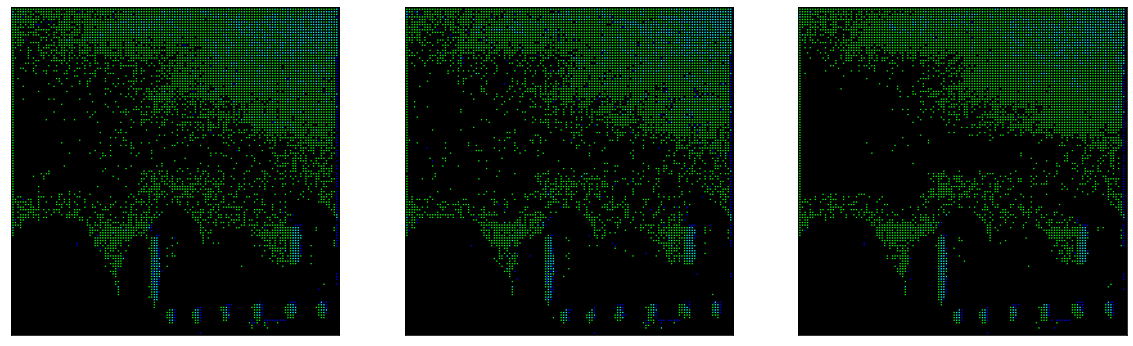

epoch 1: discriminator loss true 7.124277908587828e-05 ( 1.0 ) - discriminator loss fake 0.001933503895998001 ( 1.0 ) - generator loss 25638.330078125
epoch 2: discriminator loss true 1.928773599502165e-06 ( 1.0 ) - discriminator loss fake 0.001997989835217595 ( 1.0 ) - generator loss 13222.904296875
epoch 3: discriminator loss true 1.2577942243297002e-08 ( 1.0 ) - discriminator loss fake 0.00041274583782069385 ( 1.0 ) - generator loss 28287.46484375
epoch 4: discriminator loss true 9.151970516541041e-06 ( 1.0 ) - discriminator loss fake 2.1289273718139157e-05 ( 1.0 ) - generator loss 13193.2451171875
epoch 5: discriminator loss true 4.994038681616075e-05 ( 1.0 ) - discriminator loss fake 4.850190816796385e-05 ( 1.0 ) - generator loss 14190.45703125


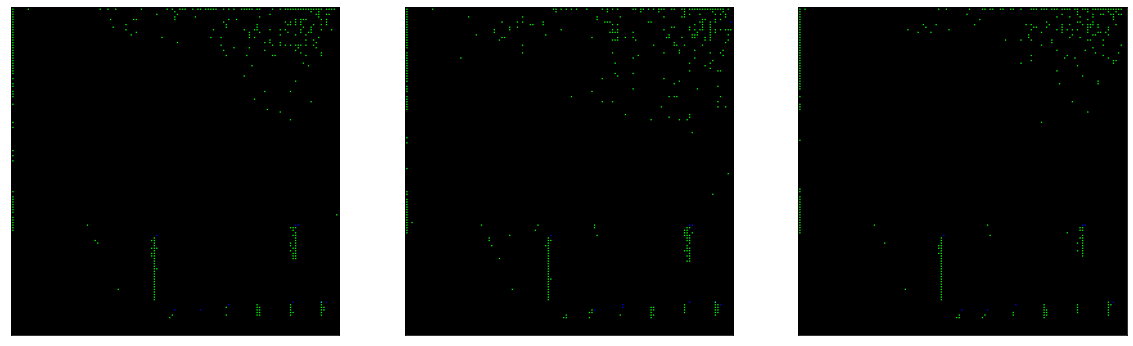

epoch 6: discriminator loss true 1.0583994480839465e-05 ( 1.0 ) - discriminator loss fake 0.0006115877185948193 ( 1.0 ) - generator loss 26692.15625
epoch 7: discriminator loss true 6.271310667216312e-06 ( 1.0 ) - discriminator loss fake 0.005566393490880728 ( 1.0 ) - generator loss 24438.375
epoch 8: discriminator loss true 3.927477365550658e-08 ( 1.0 ) - discriminator loss fake 0.0004829041427001357 ( 1.0 ) - generator loss 22401.0546875


KeyboardInterrupt: ignored

In [119]:
# train model
train(d_model, g_model, gan_model, n_epochs=20, n_batch=100)

In [ ]:
import pandas
def plot_losses(history, lim):
  pandas.DataFrame(history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,lim)
  plt.show()